In [1]:
# Load packages
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import scipy.io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, SimpleRNN
import tensorflow as tf

## Wave equation 1D

Consider the initial value problem (IVP) described by the partial differential equation for the wave equation:

$$
\frac{\partial^2 u}{\partial t^2} - c^2 \frac{\partial^2 u}{\partial x^2} = 0, \quad t > t_0, \quad x \in [a, b],
$$

This problem has analytical solutions of the form \( u(x, t) = f(x - ct) + f(x + ct) \). For example, we can choose

$$
f(y) = \frac{1}{2} \exp\left(\frac{y}{2\sigma}\right)^2
$$

to define an initial condition and evaluate it at \( u(x, t_0) \). Since it is a second-order partial differential equation, we also provide an initial condition for the velocity in the form of

$$
\left. \frac{\partial u(x, t)}{\partial t} \right|_{t=t_0}.
$$


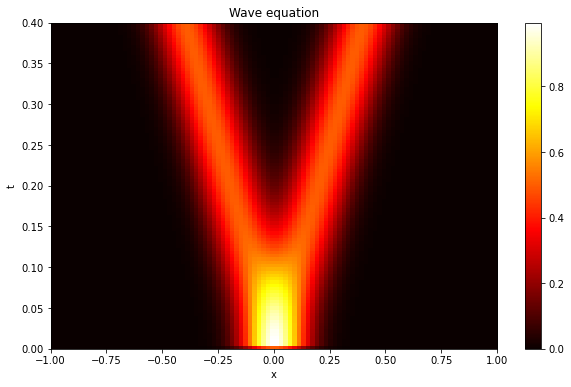

In [2]:
# Initial condition
def f(y,sigma):
    #return (1/2)*np.exp(y/(2*sigma))**2
    return (1/2)*np.exp(-y**2/(2*sigma**2))

# Find the solution
N = 100
x = np.linspace(-1,1,N)
t = np.linspace(0,0.4,N)

sigma = 0.1
c = 1

u = np.zeros((N,N))

u[:, 0] = f(x, sigma)

for j in range(1, N):
    for i in range(N):
        u[i, j] = f(x[i] - c*t[j], sigma) + f(x[i] + c*t[j], sigma)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
img = ax.imshow(u.T, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto', origin='upper', cmap='hot')
plt.gca().invert_yaxis()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Wave equation')
plt.colorbar(img)
plt.show()


## Burger's equation
Consider the PDE problem
$$u_t + \frac{1}{2} (u^2)_x = \epsilon u_{xx}, \quad -1 < x < 1, \quad t > 0,$$
$$u(x,0) = \eta(x), \quad -1 \leq x \leq 1.$$
Assume that the diffusion coefficient is a constant, $\epsilon > 0$.
Setup the problem with an initial condition, $\eta(x) = - \sin(\pi x)$. Establish convergence as a part of solving the problem using a Fourier method for $\epsilon = 0.01/\pi$ with the objective to estimate the value $u_x|_{x=0} = −152.00516$ at time $t = 1.6037 \pi$.
How accurate can you estimate this gradient?
How fast does the solver converge? Plot the evolving solution from the initial time to the final time $t$.

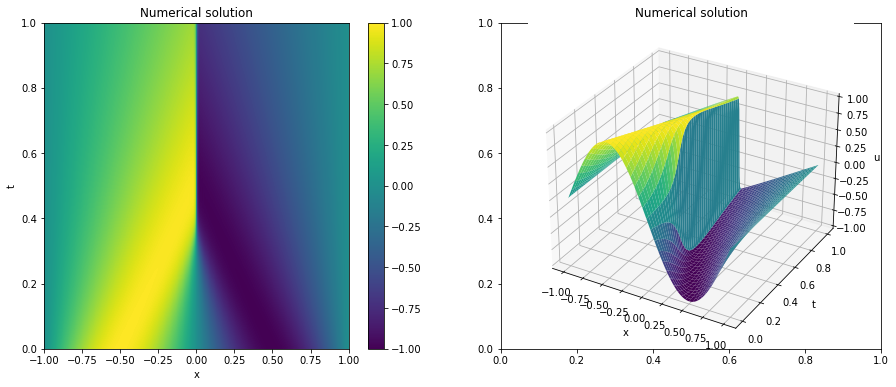

In [16]:
N = 256+1
x = np.linspace(-1,1, N)
tend = 1.6037/np.pi
tend=1
t = np.linspace(0, tend, N)

dx = x[1] - x[0]

# Initial condition
u0 = -np.sin(np.pi*x)

# Define discrete wavenumbers
kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)
epsilon = 0.01/np.pi

# Solve the ODE using fft
def rhsBurgers(u, t, kappa, epsilon):
    uhat = fft(u)
    duhat = (1j)*kappa*uhat
    dduhat = -np.power(kappa,2)*uhat
    du = ifft(duhat)
    ddu = ifft(dduhat)
    dudt = -u*du + epsilon*ddu
    return dudt.real

u = odeint(rhsBurgers, u0, t, args=(kappa,epsilon))

# Plot the solution
fig, ax = plt.subplots(1,2,figsize=(15, 6))
img = ax[0].imshow(u, extent=[x[0], x[-1], t[-1], t[0]], aspect='auto', origin='upper')
plt.colorbar(img, ax=ax[0])
ax[0].set_title('Numerical solution')
ax[0].set_xlabel('x')
ax[0].set_ylabel('t')
ax[0].invert_yaxis()  # Invert the y-axis

# Plot in 3d
X, T = np.meshgrid(x, t)
ax[1] = fig.add_subplot(122, projection='3d')
ax[1].plot_surface(X, T, u, cmap='viridis')
ax[1].set_xlabel('x')
ax[1].set_ylabel('t')
ax[1].set_zlabel('u')
ax[1].set_title('Numerical solution')
plt.show()


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

## Solve the Burgers' equation using NN